<a href="https://colab.research.google.com/github/vvvipindsm/Interview/blob/master/predcition_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiftyone
!pip install pandas 
!pip install pmdarima
!pip install seaborn 
!pip install statsmodels 
!pip install yfinance
import statsmodels.api as sm
import yfinance
import pandas as pd
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 563 kB 38.2 MB/s 
     |████████████████████████████████| 508 kB 10.8 MB/s 
     |████████████████████████████████| 132 kB 45.5 MB/s 
     |████████████████████████████████| 133 kB 7.1 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 48.3 MB 125 kB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 47 kB 3.4 MB/s 
     |████████████████████████████████| 13.2 MB 22.2 MB/s 
     |████████████████████████████████| 135 kB 48.8 MB/s 
     |████████████████████████████████| 106 kB 51.0 MB/s 
     |████████████████████████████████| 29.2 MB 49 kB/s 
     |████████████████████████████████| 226 kB 50.9 MB/s 
     |████████████████████████████████| 61 kB 261 kB/s 
     |████████████████████████████████| 7

In [ ]:
nifty_raw_data = yfinance.download (tickers = "^NSEI ^GSPC", start = "2008-01-08", 
                              end = "2022-06-27", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  2 of 2 completed


In [ ]:
df_comp = nifty_raw_data.copy()

df_comp['nifty'] = df_comp['^NSEI'].Close[:]


df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^NSEI']




df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
#spa
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100

df_comp['ret_nifty'] = df_comp.nifty.pct_change(1).mul(100)
df_comp['norm_ret_nifty'] = df_comp.ret_nifty.div(df_comp.ret_nifty[1])*100
size = int(len(df_comp)*0.8)
train, valid = df_comp.iloc[:size], df_comp.iloc[size:]
train

,nifty,spx,ret_spx,norm_ret_spx,ret_nifty,norm_ret_nifty
,,,,,,
Date,,,,,,
2008-01-09,6272.000000,1409.130005,NaN,NaN,NaN,NaN
2008-01-10,6156.950195,1420.329956,0.794813,100.000000,-1.834340,100.000000
2008-01-11,6200.100098,1401.020020,-1.359539,-171.051360,0.700832,-38.206244
2008-01-14,6206.799805,1416.250000,1.087064,136.769714,0.108058,-5.890841
2008-01-15,6074.250000,1380.949951,-2.492501,-313.595857,-2.135558,116.421052
...,...,...,...,...,...,...
2019-07-29,11189.200195,3020.969971,-0.161611,-20.333264,-0.842760,45.943522
2019-07-30,11085.400391,3013.179932,-0.257865,-32.443534,-0.927679,50.572876


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
para_index =1
model = auto_arima(train.ret_nifty[para_index:],exogenous = train[['ret_spx']][para_index:],start_q=1,max_p=6,max_q=6,m=12,seasonal=True,max_P=2, max_D=2,max_Q=2,
                            max_d=2,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True,information_criterion="aic",alpha=0.05,scoring='mse')
best_params = model.get_params()
order = best_params['order']
seasonal_order = best_params['seasonal_order']
trend = best_params['trend']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=19.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=10028.483, Time=0.41 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10029.027, Time=3.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10029.050, Time=3.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10027.059, Time=0.99 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=10030.403, Time=1.75 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=10030.398, Time=2.61 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=10031.706, Time=7.50 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=10027.051, Time=0.57 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=10029.026, Time=3.45 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=10030.394, Time=7.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=10028.990, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=10026.761, Time=2.80 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=10028.751, Time=8.33 sec
 ARIMA(1,0

In [ ]:
model

ARIMA(order=(0, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
df_auto_pred = pd.DataFrame(model.predict(n_periods = len(valid),
                            exogenous = valid[['ret_spx']]),
                            index = valid.index)

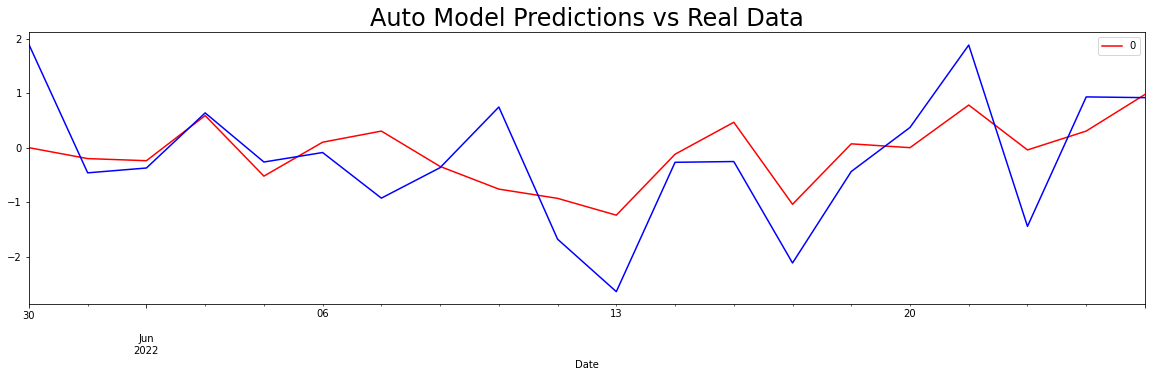

In [ ]:
df_auto_pred[-20:].plot(figsize = (20,5), color = "red")
valid.ret_nifty[-20:].plot(color = "blue",label="Test Data")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [ ]:
new_model = sm.tsa.SARIMAX(train.ret_nifty[para_index:],order=order,seasonal_order=seasonal_order,trend=trend)
fit = new_model.fit()


In [ ]:
prediction = fit.predict()
print(order)
print(seasonal_order)
print(trend)

(0, 0, 3)
(0, 0, 0, 12)
None


In [ ]:
print(prediction)
prediction_series = pd.Series(prediction)
# prediction
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(data.Value)
# valid.ret_nifty[:20].plot(color = "blue",figsize = (20,5))

# prediction_series[:20].plot(color = "red")
# plt.show()

Date
2008-01-10    0.000000
2008-01-11   -0.076876
2008-01-14    0.007524
2008-01-15    0.102057
2008-01-16   -0.129242
                ...   
2019-07-29    0.037225
2019-07-30   -0.024543
2019-07-31   -0.065625
2019-08-01    0.042517
2019-08-02   -0.006116
Freq: B, Name: predicted_mean, Length: 3017, dtype: float64


In [ ]:
futue_model = sm.tsa.ARIMA(df_comp.ret_nifty[para_index:],order=(5, 1, 0))
fit1 = fit_dd1 = futue_model.fit()
prediction1 = fit1.forecast(steps=30)

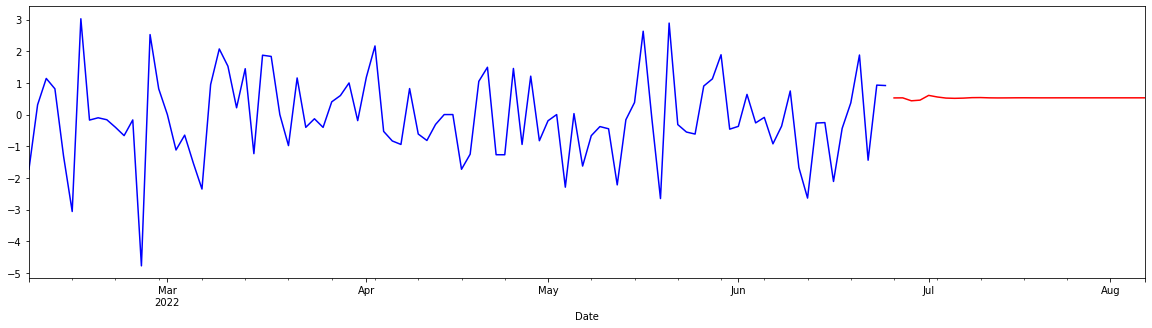

In [ ]:
prediction_series = pd.Series(prediction1)
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(data.Value)
df_comp.ret_nifty[-100:].plot(color = "blue",figsize = (20,5))
prediction = fit.forecast(steps=11)
# prediction = fit.forecast(steps=11)

prediction_series.plot(color = "red")
plt.show()

In [ ]:
from statsmodels.tsa.api import VAR